In [2]:
from collections import defaultdict
import warnings
from sys import stderr

from jupyter_server.log import log_request
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [3]:
funds_w_names = defaultdict(pd.DataFrame)

In [4]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B52VJ196','IE00B5M4WH52','IE00B66F4759','IE00B9M6RS56','IE00BD8PGZ49','IE00BDFK1573','IE00BDZVH966','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMDFDY08','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF']

In [5]:
print(etf_names)

['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS', 'IE00B0M62X26', 'IE00B14X4Q57', 'IE00B1XNHC34', 'IE00B3FH7618', 'IE00B3ZW0K18', 'IE00B52MJY50', 'IE00B52VJ196', 'IE00B5M4WH52', 'IE00B66F4759', 'IE00B9M6RS56', 'IE00BD8PGZ49', 'IE00BDFK1573', 'IE00BDZVH966', 'IE00BFNM3G45', 'IE00BHZPJ015', 'IE00BHZPJ452', 'IE00BHZPJ783', 'IE00BLDGH553', 'IE00BMDFDY08', 'IE00BMG6Z448', 'IE00BYYHSM20', 'IE00BYZTVT56', 'IE00BZ173V67', 'IE00BZ1NCS44', 'ISVIF']


In [6]:
for fund in etf_names:
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-01", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    a.fillna(method="bfill", inplace=True)
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    funds_w_names[fund] = a

In [7]:
def portfolio_factory(etfs: list):
    giga_fund = pd.DataFrame()
    c = 0
    for f in etfs:
        f.index = pd.to_datetime(f.index)  # ensure index is datetime if not already
        f["time_idx"] = (f.index.date - f.index.date[0]).astype("timedelta64[D]").astype(int)
        f['group_id'] = c
        
        giga_fund = pd.concat([giga_fund, f])
        c+= 1
    return giga_fund

In [8]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):

        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in IE.itertuples()]

        ema_for_f = sa.indicators.get_ema(quotes_for_f, 9)
        valid_ema_for_f = [
            (result.date, result.ema)
            for result in ema_for_f
            if result.ema is not None
        ]
        ema_dates, ema_values = zip(*valid_ema_for_f)

        vwma_for_f = sa.indicators.get_vwma(quotes=quotes_for_f, lookback_periods=20)
        valid_vwma_for_f = [
            (result.date, result.vwma)
            for result in vwma_for_f
            if result.vwma is not None
        ]
        vwma_dates, vwma_values = zip(*valid_vwma_for_f)

        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)

        stoch_for_f = sa.indicators.get_stoch(quotes=quotes_for_f)
        valid_stoch_for_f = [
            (result.date, result.oscillator, result.signal, result.percent_j)
            for result in stoch_for_f
            if result.date is not None and result.oscillator is not None and result.signal is not None
        ]
        stoch_dates, stoch_oscillator, stoch_signal, stoch_percent_j  = zip(*valid_stoch_for_f)

        fig, axes = plt.subplots(4, 1, figsize=(12,6))
        axes[0].plot(ema_dates[-20:], ema_values[-20:], label='EMA', linewidth=2)
        axes[0].plot(ema_dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(vwma_dates[-20:], vwma_values[-20:], label='VWMA', linewidth=2)
        axes[1].plot(vwma_dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(macd_dates[-20:], macd_values[-20:], label='MACD', linewidth=2)
        axes[2].plot(macd_dates[-20:], macd_signal[-20:], label='Signal', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(stoch_dates[-20:], stoch_oscillator[-20:], label='STOCH OSCILLATOR', linewidth=2)
        axes[3].plot(stoch_dates[-20:], stoch_percent_j[-20:], label='%J', linewidth=2)
        axes[3].plot(stoch_dates[-20:], stoch_signal[-20:], label='Signal', linewidth=2)
        axes[3].legend(loc='best')

        f['EMA'] = [x.ema for x in ema_for_f]
        f['MACD'] = [x.macd for x in macd_for_f]
        f['VWMA'] = [x.vwma for x in vwma_for_f]
        f['STOCH_OSCILLATOR'] = [x.oscillator for x in stoch_for_f]
        figs.append(fig)

        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [9]:
def fit_predict(training_cutoff_idx: pd.Timestamp, epochs: int, batch_size: int, lr: float, dropout: float, df: pd.DataFrame, independent_variables: list):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",                             # Sequential time index
        target="Close",                                  # Target variable
        group_ids=["group_id"],                          # Group identifier
        min_encoder_length=365 // 2,      # Minimum input sequence length
        max_encoder_length=365,           # Maximum input sequence length
        min_prediction_length=1,                         # Minimum forecast length
        max_prediction_length=7,     # Maximum forecast length (31 for December)
        static_reals=[],                                 # No static real variables
        time_varying_known_reals= independent_variables,  # Known inputs
        time_varying_unknown_reals=["Close"],            # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,                      # Add relative time index
        add_target_scales=True,                               # Scale the target variable
        add_encoder_length=True,                          # Include encoder length feature
        allow_missing_timesteps=False,                   # Ensure no missing steps
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True                             # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=lr,              # Learning rate
        hidden_size=16,                  # Model hidden size
        attention_head_size=1,           # Number of attention heads
        dropout=dropout,                     # Dropout rate
        hidden_continuous_size=8,        # Hidden size for continuous variables
        output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),             # Loss function
        log_interval=10,                 # Log every 10 batches
        reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",  # 
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cuda',
        devices="auto",
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_logger, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [10]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range):
    actual_values = df["Close"]["2023-12-23":]
    mse = mean_squared_error(actual_values, preds)

    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for December 23 to December 29, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return mse, plt

NO INDICATORS, ONE ETF

In [15]:
#IE00B52MJY50
IE = portfolio_factory(etfs=[funds_w_names['IE00B52MJY50']])

In [16]:
training_cutoff_date = pd.to_datetime("2023-12-22 00:00:00+01:00").tz_convert("Europe/London")
training_cutoff_idx = IE.loc[training_cutoff_date, "time_idx"]

In [17]:
IE_preds = fit_predict(training_cutoff_idx=training_cutoff_idx, epochs=12, batch_size=128, lr=1e-3, dropout=0.1, df=IE, independent_variables=["Open", "High", "Low", "Volume"])

MisconfigurationException: `CUDAAccelerator` can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

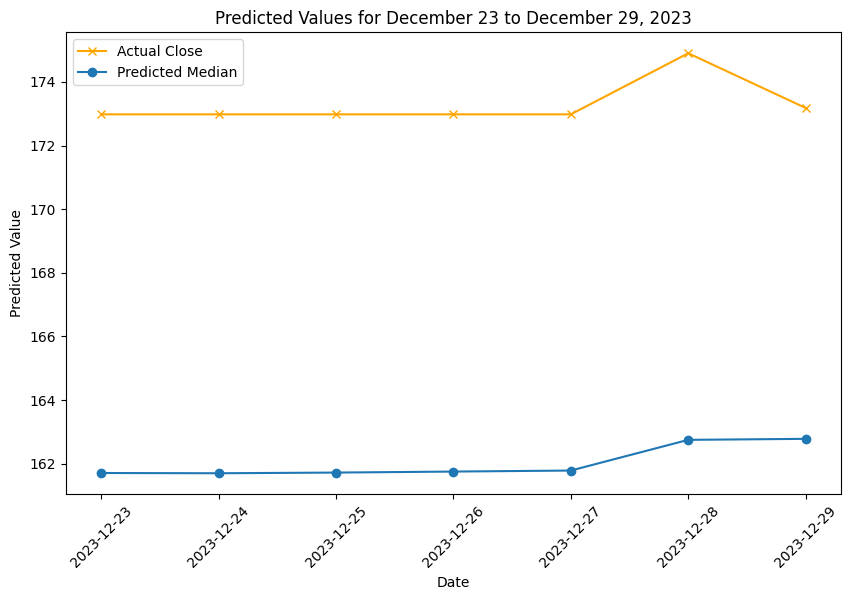

In [318]:
IE_mse, IE_plt = metrics_and_plt(IE, IE_preds, pd.date_range(start="2023-12-23", end="2023-12-29"))

ADDING INDICATORS

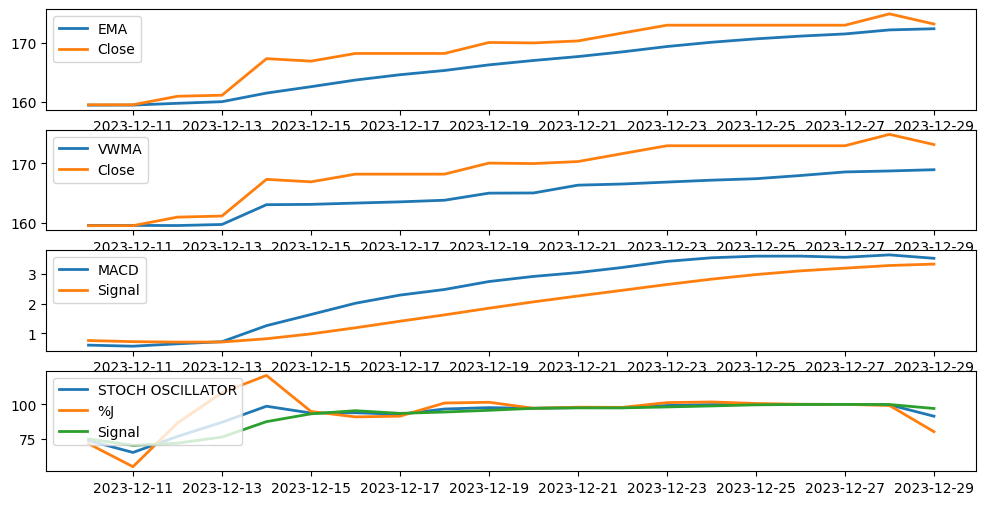

In [302]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['IE00B52MJY50']], ['IE00B52MJY50'])

In [ ]:
IE_preds = fit_predict(training_cutoff_idx=training_cutoff_idx, epochs=120, batch_size=128, lr=1e-4, dropout=0.1, df=IE, independent_variables=["Open", "High", "Low", "Volume", "EMA", "VWMA", "MACD", "STOCH_OSCILLATOR"])

In [ ]:
IE_indicators_mse, IE_indicators_plt2= metrics_and_plt(IE_preds, pd.date_range(start="2023-12-23", end="2023-12-29"))

FULL HEDGE PORTFOLIO

In [ ]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['IE00B52MJY50']], ['IE00B52MJY50'])

In [ ]:
GIGAFUND, GIGAFUND_MIN_IND = portfolio_factory(etfs=funds_w_names.values())

In [16]:
def volatility_dataset_factory(funds):
    log_returns = defaultdict(pd.DataFrame)
    for k, v in funds.items():
        print(f"{k}:")
        funds[k]["Return"] = funds[k]["Close"].pct_change()
        funds[k]["Rolling Volatility"] = funds[k]["Return"].rolling(7).std()
        funds[k].fillna(method="bfill", inplace=True)


Monte Carlo

In [17]:
def calc_drift(funds):
    drift_dict={}
    for k, v in funds.items():
        log_returns = np.log(1+funds[k]["Close"].pct_change())
        log_returns.fillna(value=0, inplace=True)
        avg_pdr = log_returns.mean()
        var = log_returns.var()
        drift = avg_pdr-(.5*var)
        drift_dict[k]=drift
    return drift_dict

In [18]:
def monte_carlo_sim(funds, drifts):
    price_paths={}
    for k, v in funds.items():
        log_returns = np.log(1+funds[k]["Close"].pct_change())
        log_returns.fillna(value=0, inplace=True)
        stdev=log_returns.std()
        days=362
        trials=100
        Z = norm.ppf(np.random.rand(days,trials))
        daily_returns=np.exp(np.array(drifts[k]) + np.array(stdev) * Z)
        price_paths[k] = np.zeros_like(daily_returns)
        price_paths[k][0] = funds[k]["Close"].iloc[-1]
        for i in range(1,days):
            price_paths[k][i] = price_paths[k][i-1] * daily_returns[i-1]
    return price_paths

In [19]:
drifts=calc_drift(funds_w_names)
pp=monte_carlo_sim(funds_w_names, drifts=drifts)

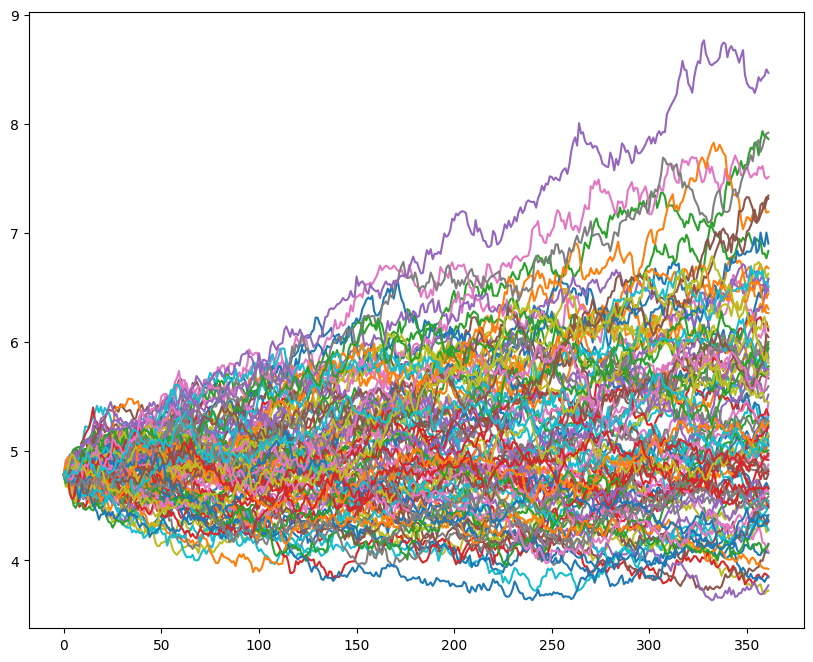

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(pp["EWSA.AS"])

CHOLESKY MONTE CARLO

In [21]:
closes = {}
covs_means = []
for k,v in funds_w_names.items():
    closes[k] = v["Close"]
closes = pd.DataFrame(closes)
r = closes.pct_change()
covariance_matix = r.cov()
mean_returns = r.mean()

In [22]:
print(covariance_matix)

              IE0005042456       EDMU.SW        EDG2.L       36BA.DE  \
IE0005042456  9.774638e-06 -1.788922e-07  6.831467e-06 -9.576234e-10   
EDMU.SW      -1.788922e-07  8.281053e-06 -1.228218e-07  4.424629e-06   
EDG2.L        6.831467e-06 -1.228218e-07  1.437719e-05 -6.125890e-10   
36BA.DE      -9.576234e-10  4.424629e-06 -6.125890e-10  4.512328e-06   
CBUS.DE      -4.307796e-10  2.847044e-06 -2.755685e-10  3.647332e-06   
EWSA.AS      -2.469864e-09  1.557972e-05 -1.579965e-09  3.700481e-06   
IE00B0M62X26 -7.169073e-10  2.212390e-06 -4.586036e-10  2.758398e-06   
IE00B14X4Q57 -5.811277e-10  6.056204e-07 -3.717457e-10  5.578386e-07   
IE00B1XNHC34  3.223761e-09  2.081883e-05  2.062231e-09  6.318427e-06   
IE00B3FH7618 -4.769765e-10  2.191218e-07 -3.051205e-10  5.843462e-08   
IE00B3ZW0K18  7.098885e-06 -3.793772e-07  7.550376e-06 -7.264360e-09   
IE00B52MJY50 -1.292666e-09  1.089148e-05 -8.269150e-10  3.961192e-06   
IE00B52VJ196 -2.425867e-09  4.388835e-06 -1.551820e-09  2.000504

In [23]:
#to be filled with real data
portfolio_weights = np.random.random(len(funds_w_names.keys())) # distribution of etfs in portfolio
portfolio_weights /= np.sum(portfolio_weights)

In [33]:
days = 60
simulations = 100
initial_port = 10000 # initial portfolio value
portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns) # days x all etfs

In [34]:
for s in range(simulations):
    Z = np.random.normal(size=(days, len(portfolio_weights)))
    L = np.linalg.cholesky(covariance_matix)
    daily_returns = mean_matrix + np.inner(L, Z)
    portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_port
        
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Simulations")

LinAlgError: Matrix is not positive definite

In [41]:
covariance_matix

,IE0005042456,EDMU.SW,EDG2.L,36BA.DE,CBUS.DE,EWSA.AS,IE00B0M62X26,IE00B14X4Q57,IE00B1XNHC34,IE00B3FH7618,IE00B3ZW0K18,IE00B52MJY50,IE00B52VJ196,IE00B5M4WH52,IE00B66F4759,IE00B9M6RS56,IE00BD8PGZ49,IE00BDFK1573,IE00BDZVH966,IE00BFNM3G45
IE0005042456,1.354430e-05,-4.068764e-07,9.466082e-06,-1.838199e-09,-8.269038e-10,-4.741013e-09,-1.376135e-09,-1.115500e-09,6.188156e-09,-9.155774e-10,9.834797e-06,-2.481330e-09,-4.656560e-09,4.077872e-06,3.626185e-06,3.014453e-06,-1.005327e-06,-1.091820e-06,0.0,9.983942e-06
EDMU.SW,-4.068764e-07,1.216404e-05,-2.793492e-07,6.418484e-06,4.072203e-06,2.296665e-05,3.181431e-06,8.557049e-07,3.072202e-05,3.089182e-07,-8.628659e-07,1.603821e-05,6.372675e-06,-6.821076e-07,-4.950376e-07,-9.234708e-07,-1.411110e-06,-1.821199e-07,0.0,-1.016722e-06
EDG2.L,9.466082e-06,-2.793492e-07,1.992213e-05,-1.175893e-09,-5.289694e-10,-3.032821e-09,-8.803121e-10,-7.135842e-10,3.958556e-09,-5.856938e-10,1.046113e-05,-1.587304e-09,-2.978796e-09,5.750824e-06,3.642423e-06,4.365243e-06,9.604153e-07,-5.389400e-07,0.0,1.127200e-05
36BA.DE,-1.838199e-09,6.418484e-06,-1.175893e-09,6.247822e-06,5.050601e-06,5.121981e-06,3.819139e-06,7.718940e-07,8.756056e-06,8.041740e-08,-1.394428e-08,5.486045e-06,2.767616e-06,-7.216594e-09,-6.443422e-09,-4.636929e-09,-1.124171e-10,-1.277376e-09,0.0,-1.783231e-08
CBUS.DE,-8.269038e-10,4.072203e-06,-5.289694e-10,5.050601e-06,9.067215e-06,3.180912e-06,4.778804e-06,1.173602e-06,4.997734e-06,1.161589e-07,-6.272761e-09,2.502022e-06,1.098726e-06,-3.246347e-09,-2.898539e-09,-2.085898e-09,-5.057025e-11,-5.746208e-10,0.0,-8.021770e-09
EWSA.AS,-4.741013e-09,2.296665e-05,-3.032821e-09,5.121981e-06,3.180912e-06,3.101535e-05,2.566389e-06,2.266366e-07,2.881483e-05,6.708201e-08,-3.596457e-08,2.008036e-05,1.091041e-05,-1.861277e-08,-1.661863e-08,-1.195939e-08,-2.899421e-10,-3.294560e-09,0.0,-4.599243e-08
IE00B0M62X26,-1.376135e-09,3.181431e-06,-8.803121e-10,3.819139e-06,4.778804e-06,2.566389e-06,5.522257e-06,1.029623e-06,4.261705e-06,1.029327e-07,-1.043914e-08,1.577011e-06,1.119599e-06,-5.402578e-09,-4.823756e-09,-3.471356e-09,-8.415913e-11,-9.562852e-10,0.0,-1.334985e-08
IE00B14X4Q57,-1.115500e-09,8.557049e-07,-7.135842e-10,7.718940e-07,1.173602e-06,2.266366e-07,1.029623e-06,3.774094e-07,3.257013e-07,5.950636e-08,-8.462007e-09,6.543336e-08,-3.800697e-08,-4.379349e-09,-3.910154e-09,-2.813894e-09,-6.821969e-11,-7.751682e-10,0.0,-1.082144e-08
IE00B1XNHC34,6.188156e-09,3.072202e-05,3.958556e-09,8.756056e-06,4.997734e-06,2.881483e-05,4.261705e-06,3.257013e-07,7.005509e-05,-1.797465e-07,4.694237e-08,2.806912e-05,1.757643e-05,2.429412e-08,2.169129e-08,1.560987e-08,3.784438e-10,4.300189e-09,0.0,6.003113e-08
IE00B3FH7618,-9.155774e-10,3.089182e-07,-5.856938e-10,8.041740e-08,1.161589e-07,6.708201e-08,1.029327e-07,5.950636e-08,-1.797465e-07,3.705802e-08,-6.945425e-09,-5.141899e-09,-4.054385e-08,-3.594471e-09,-3.209366e-09,-2.309580e-09,-5.599318e-11,-6.362406e-10,0.0,-8.881990e-09
